In [71]:
import os, glob

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.utils.data as data

import torchvision.transforms as transforms
from torchvision.io import read_image

In [72]:
class Dataset(data.Dataset):
    def __init__(self, image_path, transform = None):
        super().__init__()
        self.img_files = glob.glob(os.path.join(image_path, '*.jpg'))
                
        if transform:
            self.transform = transform
        else:
            self.transform = transforms.Compose([
                                                transforms.ToPILImage(),
                                                transforms.ToTensor()])

    def __getitem__(self, index):
        img_path = self.img_files[index]

        name = os.path.splitext(os.path.basename(img_path))[0]

        image = read_image(img_path)
        image = self.transform(image)

        return image, name

    def __len__(self):
        return len(self.img_files)

In [73]:
def tensor_to_image(tensor):
    new_image = np.empty( (tensor.size()[1], tensor.size()[2]) )
    new_image[:,:] = tensor[0,:,:]
    return new_image

def show(image, title=None):
    fig, ax = plt.subplots(1,1)
    fig.tight_layout()
    ax.imshow(image, cmap="gray")
    ax.axis('off')
    if title:
        fig.suptitle(title)
    plt.show()

In [74]:
route = "ship_dataset/"

my_transforms = transforms.Compose([
                                    transforms.ToPILImage(),
                                    transforms.Resize((144, 256)),
                                    transforms.ToTensor()
])

ship_dataset = Dataset(f"{route}/images", transform=my_transforms)
print(len(ship_dataset))

167


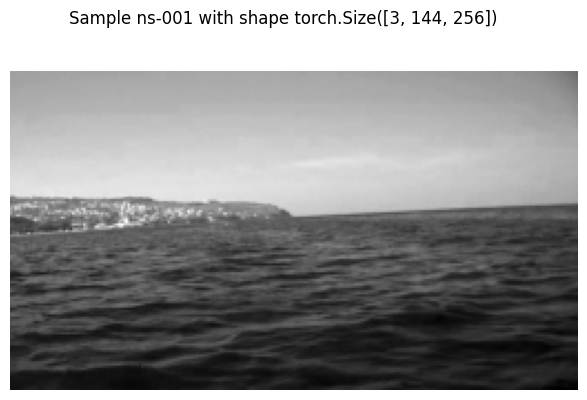

In [ ]:
image, name = ship_dataset[0]
show(tensor_to_image(image), title=f"Image {name} with shape {image.shape}")